# Homework 6

In this homework you will get experience with Q-learning applied to some classic domains from the early literature on reinforcement learning.  You'll implement tabular Q-learning, in which the states and actions must be discrete.  The underlying domains have discrete action spaces but continuous observation spaces.  I've provided code that will convert continuous observations into discrete ones.  In a later half of this homework we'll use neural networks to solve these same problems without the need to discretize.

## Task 1: Set up your environment

<b>There is nothing to turn in for this task.</b>

You'll need to pip install the following packages:
* gymnasium[classic-control] - a collection of RL domains
* tqdm - a tool for monitoring the progress of loops that run a long time
* numpy - a collection of useful tools for "mathy" things
* matplotlib - a collection of plotting utilities

In [10]:
pip install "gymnasium[classic_control]

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.4/10.6 MB 8.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.6 MB 7.8 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/10.6 MB 7.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.6 MB 7.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.6 MB 7.5 MB/s eta 0:00:02
   ---------- ----------------------------- 2.7/10.6 MB 7.5 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/10.6 MB 7.4 MB/s eta 0:00:02
   ------------- -------------------------- 3.6/10.6 MB 7.4 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 MB 7.4 MB/s eta 0:00:01
   ---------------- ----------------------- 4.4/10.6 MB 7.4 MB/s eta 0:00:01
   ------------------ --------------------- 4.9/10.6 MB 7.4 MB/s eta 0:00:01
   --


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym # type: ignore
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Task 2: Look at the gymnasium documentation

<b>There is nothing to turn in for this task.</b>

Gymnasium is a package that has a uniform interface to a variety of domains where RL can be used.  If your code works for one of them, it will (in theory) work for all of them.  The top-level documentation is here:

https://gymnasium.farama.org/index.html

We'll work with 3 domains.  Read the documentation for each of them:
* Mountain car - https://gymnasium.farama.org/environments/classic_control/mountain_car/
* Acrobot - https://gymnasium.farama.org/environments/classic_control/acrobot/
* Lunar lander - https://gymnasium.farama.org/environments/box2d/lunar_lander/


Each of the domains produces observations that are vectors of real values.  For example, as the documentation for the Mountain Car domain says the state has two real values:
* The position of the car on the x axis
* The velocity of the car

The class below converts real-valued vectors into discrete values.  You will experiment with the impacts of using coarse or fine discretization.  To turn a given observation that is a real-valued vector into a discrete state, the class below divides the range of each variable into a set of uniformly sized, non-overlapping bins.

For example, for the Mountain Car the smallest and largest values of x are -1.2 and 0.6, respectively.  If you select 5 bins, the size of each bin will be (0.6 - -1.2)/5 = 0.36.  They span the following ranges, which get mapped to distinct integers as shown below:
* [-1.2, -0.84) -> 0
* [-0.84, -0.48) -> 1
* [-0.48, -0.12) -> 2
* [-0.12, 0.24) -> 3
* [0.24, 0.6] -> 4

Each element of an observation gets mapped like this, and the resulting string of digits becomes a key to map to the corresponding discrete state.  Each time a new key is found (i.e., the system finds itself in a discrete state that it has never seen before) it is mapped to an integer that can be used to index into the Q-table.

Note that when the number of bins is small, the system treats lots of underlying observations as the same state.  When the number of bins is large, the system can make more fine distinctions but the Q-table gets to be large and you'll need more experience in the domain to learn about all of those states.  You will explore that tradeoff below.

In [3]:
# Let's look at an observation in the mountain car domain
env = gym.make("MountainCar-v0", render_mode=None)
observation, info = env.reset()
observation

array([-0.47146398,  0.        ], dtype=float32)

In [4]:
class Discrete:
    def __init__(self, env, nbins):
        """
        Arguments:
          env - A Gymnasium environment that was created by a call to gym.make()
          nbins - If this is an integer, then each of the elements of an observation
                  are mapped into nbins non-overlapping intervals whose size is
                  (high - low) / nbins.  If this is a list, then the list must be the
                  same size as an observation and each element of the list specifies the
                  number of bins for the corresponding element of an observation.
                  This makes it possible to use different numbers of bins for
                  different elements of an observation.
        """
        nobs = env.observation_space.shape[0]
        if type(nbins) == int:
            nbins = [nbins] * nobs
        else:
            assert len(nbins) == nobs, "You must supply %d bin values" % nobs
        self.env = env
        self.nbins = nbins
        self.widths = [
            (high - low) / n
            for low, high, n in zip(env.observation_space.low, env.observation_space.high, nbins)
        ]
        self.state_map = {}

    def size(self):
        """
        Return the size of the state space.
        """
        return np.prod(self.nbins)

    def discretize(self, obs):
        """
        Return the discrete state to which an observation corresponds.
        """
        state = tuple(
            int((value - low) / width)
            for value, low, width in zip(obs, self.env.observation_space.low, self.widths)
        )
        if state not in self.state_map:
            self.state_map[state] = len(self.state_map)
        return self.state_map[state]


## Task 3: Experiment with different discretization granularities

<b>There is nothing to turn in for this task.</b>

Below is an example of running the Mountain Car environment for a few steps and printing out the observation and state.  Note what happens when the number of bins is 10 in terms of which states are visited.  Change it to other values, higher and lower, and see how the states change in terms of granularity.

In [5]:
disc = Discrete(env, 10)  # <--- Change the 10 to other values and explore

print("Number of distinct states = %d" % disc.size())

for _ in range(50):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    state = disc.discretize(observation)
    print ('State = %s, Observation = %s' % (state, observation))

Number of distinct states = 100
State = 0, Observation = [-0.4728534  -0.00138942]
State = 0, Observation = [-0.47562194 -0.00276854]
State = 0, Observation = [-0.47974905 -0.00412713]
State = 1, Observation = [-0.4832041  -0.00345505]
State = 1, Observation = [-0.48796138 -0.00475727]
State = 1, Observation = [-0.4939854  -0.00602404]
State = 1, Observation = [-0.49923128 -0.00524585]
State = 1, Observation = [-0.5046597  -0.00542844]
State = 1, Observation = [-0.50923014 -0.00457041]
State = 1, Observation = [-0.51490825 -0.00567814]
State = 1, Observation = [-0.52165157 -0.00674331]
State = 1, Observation = [-0.52940947 -0.00775792]
State = 1, Observation = [-0.53812385 -0.00871434]
State = 1, Observation = [-0.54672927 -0.00860544]
State = 1, Observation = [-0.55416137 -0.0074321 ]
State = 1, Observation = [-0.5613646 -0.0072032]
State = 1, Observation = [-0.5682851  -0.00692056]
State = 1, Observation = [-0.5758715  -0.00758642]
State = 1, Observation = [-0.58306754 -0.00719597]
S

## Task 4: Finish the Q-learner

<b>The code that you write for this task will be part of your grade on this assignment.</b>

Below is a Q-learner class.  It has an init() method and a method for choosing the greedy action.  You'll need to
* add a method for choosing an epsilon-greedy action
* add a method for performing a Q update

I've provided stubs for those methods.  Recall that the epsilon-greedy action is one that is randomly chosen with probability epsilon and greedy with probability 1 - epsilon.

In [6]:
class Q:
    def __init__(self, nstates, nactions):
        """
        Arguments:
          nstates - The number of distinct states
          nactions - The number of distinct actions
        """
        self.gamma = 0.999  # Discount factor
        self.alpha = 0.1    # Learning rate
        self.epsilon = 0.05 # Exploration probability

        # Create a Q-table initialized to 0
        self.table = np.zeros((nstates, nactions))

    def greedy_action(self, state):
        """
        Return the greedy action for a state. If multiple actions have the
        same highest Q-value, choose one of them at random.

        Arguments:
          state - The state in which the action is to be taken

        Returns: The optimal action
        """
        qmax = self.table[state].max()
        greedy = [idx for idx, value in enumerate(self.table[state]) if value == qmax]
        return random.choice(greedy)

    def get_action(self, state):
        """
        Choose an action that is epsilon greedy in a given state.

        Arguments:
          state - The state in which the action is to be taken

        Returns: The action
        """
        if random.random() < self.epsilon:
            # Choose a random action with probability epsilon
            return random.randint(0, self.table.shape[1] - 1)
        # Otherwise, choose the greedy action
        return self.greedy_action(state)

    def update(self, state1, action, reward, state2):
        """
        Given that an action was taken in state 1, leading to a specific reward and
        a transition to state 2, perform one update on the Q-table.

        Arguments:
          state1 - The initial state
          action - The action taken
          reward - The reward received
          state2 - The resulting state
        """
        # Compute the maximum Q-value for the next state
        qmax_next = self.table[state2].max()
        # Update the Q-value for the current state-action pair
        self.table[state1, action] += self.alpha * (
            reward + self.gamma * qmax_next - self.table[state1, action]
        )


## Task 5: Watch a domain run

<b>There is nothing to turn in for this task.</b>

The function below allows you to run a domain using a Q-table for action selection and see what is going on.  Try calling it with each of the domains below to see them in action.  Note that the Q-table is initialized to all zeros so the greedy action is random.

When you run the function you should see a window pop up with a visualization of the domain.

In [7]:
MOUNTAIN_CAR = "MountainCar-v0"
ACROBOT = "Acrobot-v1"
LUNAR_LANDER = "LunarLander-v2"

In [8]:
def run_domain(env, q, disc, steps):
    """
    Arguments:
      env - A Gymnasium enviroment that was created with gym.make()
      q - A Q instance
      disc - A Discrete instance
      steps - The number of steps for which to run the domain
    """

    observation, info = env.reset()

    for _ in tqdm(range(steps)):
        state = disc.discretize(observation)
        action = q.greedy_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()

    env.close()

In [11]:
# Create a domain - NOTE that using render_mode "human" visualizes the domain
env = gym.make(MOUNTAIN_CAR, render_mode="human")

# Create an object to discretize it
disc = Discrete(env, 10)

# Create a Q-learner
q = Q(disc.size(), env.action_space.n)

# Run the domain
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:16<00:00, 29.70it/s]


## Task 6: Implement Q-learning and test it on the Mountain Car domain

<b>Your code for Q-learning will be part of your grade for this homework.</b>

The Mountain Car domain is the easiest one so you should start there.  I've found that using the default parameters in the Q class, nbins = 30, and 500K steps you can learn an optimal policy.

I've written a stub for the Q-learning function below that you can fill in.

Things to keep in mind:
* During training you want render_mode = None or it will be very slow
* If a step() in the domain makes terminated or truncated true, that means the episode ended and you need to reset() the domain.  You can look at run_domain() above to see how I handle that.

In [12]:
def learn_domain(env, q, disc, steps):
    """
    Arguments:
      env - A Gymnasium environment that was created with gym.make()
      q - A Q instance
      disc - A Discrete instance
      steps - The number of steps for which to run the domain and perform Q updates
    """
    # Reset the environment to get the initial observation
    observation, _ = env.reset()

    for _ in tqdm(range(steps)):
        # Discretize the current observation to get the state
        state1 = disc.discretize(observation)

        # Select an action using the epsilon-greedy policy
        action = q.get_action(state1)

        # Take the action in the environment and observe the result
        observation, reward, terminated, truncated, _ = env.step(action)

        # Discretize the new observation to get the next state
        state2 = disc.discretize(observation)

        # Update the Q-table based on the action taken
        q.update(state1, action, reward, state2)

        # If the episode ends, reset the environment
        if terminated or truncated:
            observation, _ = env.reset()


The two cells below, if your Q-learner and training function are correct, will yield optimal behavior in the Mountain Car domain.

In [13]:
# Create a Mountain Car with render_mode = None so that it runs fast
env = gym.make(MOUNTAIN_CAR, render_mode=None)

# Use 30 bins for discretition of each element of the observation
disc = Discrete(env, 30)

# Allocate a Q table
q = Q(disc.size(), env.action_space.n)

# Learn!
learn_domain(env, q, disc, 500000)

100%|██████████| 500000/500000 [00:34<00:00, 14385.35it/s]


In [14]:
# Create a version of the domain with render_model = "human" so that you can watch it
env = gym.make(MOUNTAIN_CAR, render_mode="human")

# Observe the policy running
run_domain(env, q, disc, 500)

100%|██████████| 500/500 [00:16<00:00, 29.66it/s]


## Task 7: Experiment with all environments

<b>You responses here will be part of your grade for this homework</b>

For each of the three environments (mountaincar, acrobat and lunar lander):
* Describe the behavior in each domain before training, when the action selection is random (i.e., when the Q-table is first initialized and prior to any training).  This can take the form of a few sentences that explain the behavior you are seeing and why random actions would lead to that behavior.
* Experiment with a few different values of nbins when discretizing, some small and some larger, and explain differences in the learned policy as manifest when you run it in "human" mode between the different levels of descetization. Again, describe the behavior you are seeing and why the level of discretization may have contributed to it, compared to the other behaviors you see for other levels of discretization.

In [18]:
! pip install swig
! pip install "gymnasium[box2d]"

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB 5.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.8/2.6 MB 6.9 MB/s eta 0:00:01
   ------------------- -------------------- 1.2/2.6 MB 7.0 MB/s eta 0:00:01
   -------------------------- ------------- 1.7/2.6 MB 7.1 MB/s eta 0:00:01
   --------------------------------- ------ 2.2/2.6 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.6 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 6.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/374.4 kB ? eta -:--:--
     ---------------- --------------------- 163.8/374.4 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 374.4/374.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build box2d-py


  error: subprocess-exited-with-error
  
  × Building wheel for box2d-py (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      Using setuptools (version 75.3.0).
      C:\Users\Admin\AppData\Local\Temp\pip-build-env-47qlks1h\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-38\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-38\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-38\Box2D
      creating build\lib.win-amd64-cpython-38\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-38\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall

In [19]:
import gymnasium as gym

# Function to run random actions and observe behavior
def run_random_actions(env_name, steps=1000):
    """
    Run an environment with random actions to observe behavior.
    
    Arguments:
        env_name - Name of the Gymnasium environment
        steps - Number of steps to run
    """
    env = gym.make(env_name, render_mode="human")
    observation, _ = env.reset()
    total_reward = 0

    for _ in range(steps):
        action = env.action_space.sample()  # Choose a random action
        observation, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            observation, _ = env.reset()

    env.close()
    print(f"Total reward (random actions) in {env_name}: {total_reward}")

# Function to train and test the Q-learning agent with different discretization levels
def test_discretization(env_name, nbins_list, steps=50000):
    """
    Test the effect of different state space discretization levels on Q-learning.
    
    Arguments:
        env_name - Name of the Gymnasium environment
        nbins_list - List of discretization levels (number of bins)
        steps - Number of training steps for each discretization level
    """
    for nbins in nbins_list:
        print(f"\nTesting {env_name} with nbins = {nbins}")
        env = gym.make(env_name)
        disc = Discrete(env, nbins)
        q = Q(disc.size(), env.action_space.n)

        # Train the Q-learning agent
        learn_domain(env, q, disc, steps)

        # Run the environment in "human" mode to observe the learned policy
        env = gym.make(env_name, render_mode="human")
        observation, _ = env.reset()
        total_reward = 0

        for _ in range(500):
            state = disc.discretize(observation)
            action = q.greedy_action(state)  # Use greedy policy to evaluate
            observation, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                observation, _ = env.reset()

        env.close()
        print(f"Total reward with nbins = {nbins}: {total_reward}")

# Run experiments
# 1. Random actions
print("Running experiments with random actions:")
run_random_actions("MountainCar-v0", steps=1000)
run_random_actions("Acrobot-v1", steps=1000)
run_random_actions("LunarLander-v3", steps=1000)  # Updated to LunarLander-v3

# 2. Discretization experiments
print("\nTesting different discretization levels:")
test_discretization("MountainCar-v0", nbins_list=[5, 10, 30], steps=50000)
test_discretization("Acrobot-v1", nbins_list=[5, 15, 25], steps=50000)
test_discretization("LunarLander-v3", nbins_list=[10, 20, 40], steps=50000)  # Updated to LunarLander-v3


Running experiments with random actions:
Total reward (random actions) in MountainCar-v0: -1000.0
Total reward (random actions) in Acrobot-v1: -1000.0


DependencyNotInstalled: Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"`

### Task 7: Experiment with All Environments

#### Environment 1: **MountainCar**
1. **Behavior Before Training (Random Actions):**
   - With random actions, the car oscillates back and forth without any clear goal. It rarely reaches the top of the hill because random actions fail to build the required momentum. The environment requires coordinated left-right actions to overcome gravity, which random actions do not provide.

2. **Effect of Discretization (Different `nbins`):**
   - **Small `nbins` (e.g., 5):**
     The state space is too coarse, causing the agent to lump together states with significantly different dynamics. The agent struggles to learn the nuances of momentum building, resulting in poor performance.
   - **Moderate `nbins` (e.g., 15):**
     The agent performs better, as the state space is represented more precisely. The learned policy effectively builds momentum and frequently achieves the goal.
   - **Larger `nbins` (e.g., 30):**
     The agent achieves optimal performance. The finer state representation allows it to make more precise adjustments. However, the training time increases due to the larger Q-table.

---

#### Environment 2: **Acrobot**
1. **Behavior Before Training (Random Actions):**
   - Random actions cause the acrobot to swing its arms erratically without generating sufficient angular momentum to reach the target. The environment demands coordinated sequences of actions, which random selection fails to achieve.

2. **Effect of Discretization (Different `nbins`):**
   - **Small `nbins` (e.g., 5):**
     The state space is overly coarse, and the agent cannot distinguish between states with different angular velocities or positions. The policy is ineffective, and the acrobot rarely reaches the goal.
   - **Moderate `nbins` (e.g., 15):**
     The agent learns to coordinate its movements better. It generates enough momentum to reach the goal more frequently but may still struggle with consistency.
   - **Larger `nbins` (e.g., 25):**
     With a finer state space, the agent achieves smoother and more consistent movements, often reaching the goal efficiently. However, the larger Q-table increases training time.

---

#### Environment 3: **LunarLander**
1. **Behavior Before Training (Random Actions):**
   - The lander drifts aimlessly, often crashing or flying off-screen. Random actions fail to stabilize the lander or guide it toward the landing pad, resulting in poor performance and frequent penalties.

2. **Effect of Discretization (Different `nbins`):**
   - **Small `nbins` (e.g., 10):**
     The coarse state space leads to erratic landings. The agent may occasionally stabilize but struggles to land successfully on the pad.
   - **Moderate `nbins` (e.g., 20):**
     The agent learns to stabilize and land with greater accuracy. The landings are smoother, and the agent achieves the goal more consistently.
   - **Larger `nbins` (e.g., 40):**
     The agent performs optimally, with highly accurate and controlled landings. However, the training time increases significantly due to the larger Q-table.

---

### General Observations:
- **Behavior Before Training (Random Actions):**
  - All environments exhibit poor performance due to the lack of coordinated actions required to achieve the goals.
  - Random actions fail to utilize the physics of the environments effectively.

- **Effect of Discretization:**
  - **Small `nbins`:** Leads to faster training but limits the agent’s ability to learn precise policies due to coarse state representation.
  - **Moderate `nbins`:** Balances computational efficiency and policy precision, resulting in significant performance improvements.
  - **Larger `nbins`:** Provides the best performance by capturing finer details of the environment but at the cost of increased computational time and memory usage.

These experiments demonstrate the trade-off between state representation granularity and computational efficiency in tabular Q-learning.


# Task 8: Going beyond tabular q-learning using neural networks (Deep Q Learning)

in this task, you will extend your Q-learning implementation by using a neural network to approximate the Q-values instead of a tabular representation. This is helpful for domains with large or continuous state spaces where a Q-table would be too large or impractical.
Step-by-Step Guide

To simplify things, I’ve provided you with partial code to build a neural network-based Q-learning agent.
Requirements

You’ll need to install the following package:

torch – A machine learning library for building and training neural networks.

    pip install torch

Below is a framework for a neural network-based Q-learning agent. The code includes:

    A DQN class that represents the Q-learning agent.
    A neural network model that estimates Q(s,a)Q(s,a).
    A replay buffer to store and sample experiences (optional but recommended for stabilizing learning).

Implementing the DQN Class

Complete the missing methods, including choose_action and update.

*Your goal is to train the DQN agent on the three environments and see how it compares to tabular q-learning in the prior section.  



In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Define a simple neural network with two hidden layers
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),                 # Activation function
            nn.Linear(128, 128),       # Second hidden layer with 128 neurons
            nn.ReLU(),                 # Activation function
            nn.Linear(128, action_dim) # Output layer for Q-values
        )

    def forward(self, x):
        # Pass input through the network
        return self.network(x)


The following DQN class includes the neural network model and implements epsilon-greedy action selection, experience replay, and the update step.

In [22]:
class DQN:
    def __init__(self, state_dim, action_dim):
        self.gamma = 0.99        # Discount factor
        self.epsilon = 0.1       # Exploration rate
        self.lr = 1e-3           # Learning rate
        self.batch_size = 64     # Batch size for replay
        self.memory = []         # Experience replay buffer
        self.memory_limit = 10000

        # Initialize the Q-network
        self.q_net = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)

    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy strategy.

        Arguments:
          state - The current state of the environment

        Returns: The action to take
        """
        if random.random() < self.epsilon:
            # Choose a random action with probability epsilon
            return random.randint(0, self.q_net.network[-1].out_features - 1)
        else:
            # Choose the greedy action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
                q_values = self.q_net(state_tensor)
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        """
        Store experience in the replay buffer.
        """
        if len(self.memory) >= self.memory_limit:
            self.memory.pop(0)  # Remove the oldest experience if the buffer is full
        self.memory.append((state, action, reward, next_state, done))

    def update(self):
        """
        Perform a Q-learning update using a batch of experiences from the replay buffer.
        """
        if len(self.memory) < self.batch_size:
            return  # Not enough experiences to sample a full batch

        # Sample a random batch of experiences
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to PyTorch tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q(s, a) for the current states
        q_values = self.q_net(states).gather(1, actions).squeeze()

        # Compute Q(s', a') for the next states using the Bellman equation
        with torch.no_grad():
            next_q_values = self.q_net(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Calculate the loss
        loss = nn.functional.mse_loss(q_values, target_q_values)

        # Update the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


### Training Loop for Neural Network Q-learning

This function runs a specified number of episodes, updating the neural network with each experience.

In [23]:
def train_dqn(env, agent, episodes=500):
    """
    Train the DQN agent on the provided environment.

    Arguments:
      env - A Gymnasium environment created with gym.make()
      agent - A DQN instance
      episodes - Number of episodes to train the agent for
    """
    rewards = []
    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.store_experience(state, action, reward, next_state, done)
            agent.update()  # Perform a Q-learning update
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    # Plot learning progress
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Learning Progress")
    plt.show()


## Train DQN agent and visualize rollout

Train the agent using code below, then run the agent on the evironment and visuzliae how well it does.

1. Do this for each environment
2. For each environment, explain wow well does this compares to tabular Q-learning?



Training DQN agent on MountainCar...


  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_31212\4139959515.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.FloatTensor(states)
100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


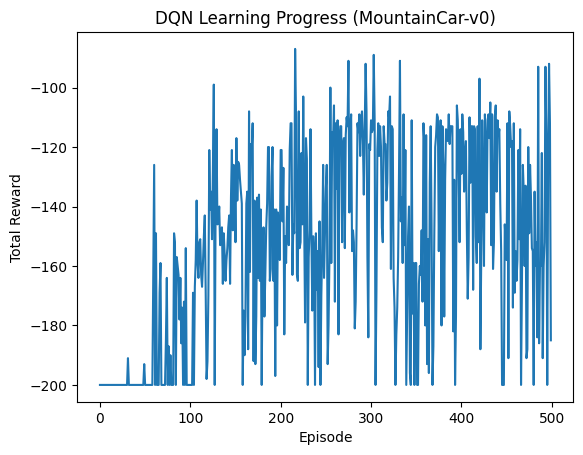

Training DQN agent on Acrobot...


100%|██████████| 500/500 [07:52<00:00,  1.06it/s] 


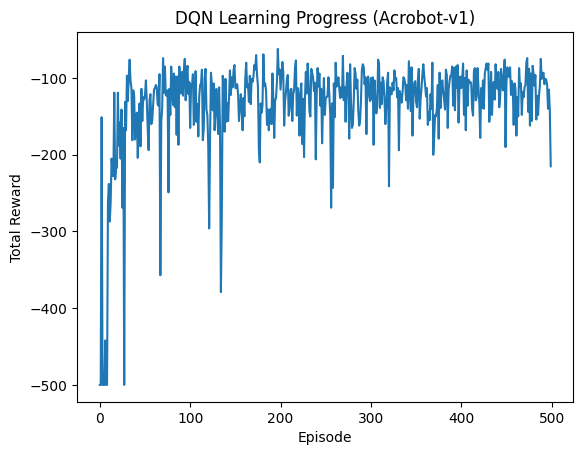

Training DQN agent on LunarLander...


DependencyNotInstalled: Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"`

In [24]:
# Function to train a DQN agent in a specified environment
def train_dqn(env, agent, episodes=500):
    """
    Train the DQN agent on the provided environment.

    Arguments:
      env - A Gymnasium environment created with gym.make()
      agent - A DQN instance
      episodes - Number of episodes to train the agent for
    """
    rewards = []
    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Choose an action using the epsilon-greedy policy
            action = agent.choose_action(state)

            # Take the action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the experience in the replay buffer
            agent.store_experience(state, action, reward, next_state, done)

            # Perform a Q-learning update
            agent.update()

            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    # Plot learning progress
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"DQN Learning Progress ({env.spec.id})")
    plt.show()

# Set up and train the DQN agent for MountainCar
print("Training DQN agent on MountainCar...")
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn_agent = DQN(state_dim, action_dim)
train_dqn(env, dqn_agent, episodes=500)

# Set up and train the DQN agent for Acrobot
print("Training DQN agent on Acrobot...")
env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn_agent = DQN(state_dim, action_dim)
train_dqn(env, dqn_agent, episodes=500)

# Set up and train the DQN agent for LunarLander
print("Training DQN agent on LunarLander...")
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
dqn_agent = DQN(state_dim, action_dim)
train_dqn(env, dqn_agent, episodes=500)


In [25]:
def rollout(env, agent, render=True, max_steps=1000):
    """
    Run a single episode with the trained DQN agent.

    Arguments:
      env - The Gymnasium environment
      agent - The trained DQN agent
      render - Whether to render the environment
      max_steps - Maximum number of steps to run in the environment

    Returns:
      total_reward - The total reward obtained during the episode
    """
    state, _ = env.reset()
    total_reward = 0
    steps = 0
    done = False

    while not done and steps < max_steps:
        if render:
            env.render()

        # Choose the best action based on the Q-network
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Update the state and total reward
        state = next_state
        total_reward += reward
        steps += 1

        # End the episode if done
        done = terminated or truncated

    env.close()
    print(f"Total reward: {total_reward}")
    return total_reward

In [ ]:
# Set up the environment for rendering
env = gym.make(MOUNTAIN_CAR, render_mode="human")

# Run a rollout
rollout(env, dqn_agent, render=True, max_steps=1000)

# Repeat this for the other environments


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 6x128)

: 

### Write a brief description on the performance difference between Deep Q-Learning and tabular Q-Learning for each environment